# Setting up DeepRoute's Controller in TACC site and Stitching to Exogeni site
  
Setting up DeepRoute's Controller in TACC site and Stitching it to Exogeni site. Chameleon's DirectStitch capabilities enables direct OSI layer 2 connections and the associated wide-area networking experiments as described.
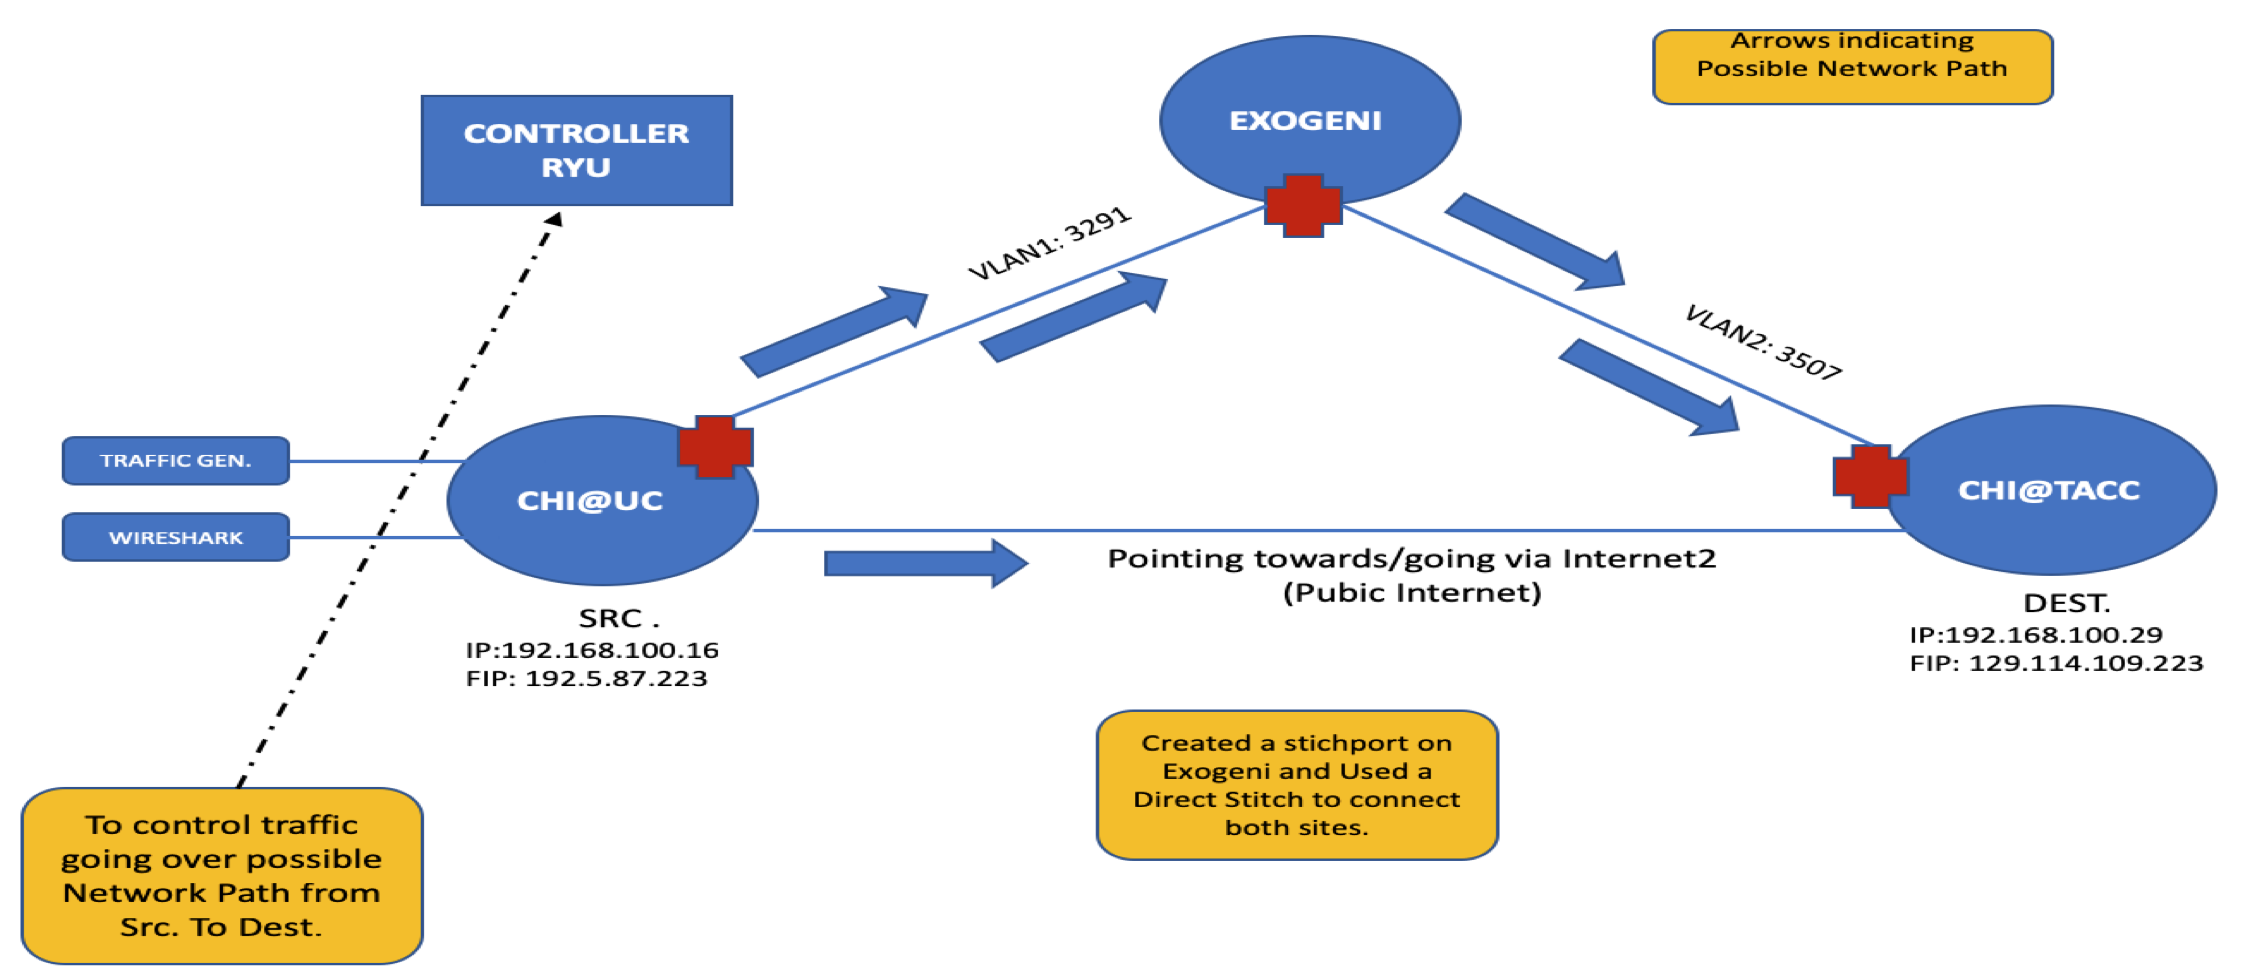

#### Setup DeepRoutes's Controller Environment @ TACC

In [1]:
# Set up user's project (user's can be multiple ones, so there is no default currently)
export OS_PROJECT_NAME='MC4N'

# Set region (again, no default currently)
export OS_REGION_NAME='CHI@TACC'

# Set chameleon keypair name and path to the private ssh key
export SSH_KEY_NAME=tac-key
export SSH_PRIVATE_KEY=${HOME}/work/bashir-chameleon-jupyter


# Set the reservations to use.  
# CONTROLLER_RESERVATION_ID can be for any type of node
# NODE_RESERVATION_ID must be for Skylake nodes
export CONTROLLER_RESERVATION_ID='d3ea7ec0-6153-4d3c-bf1f-3badc056bba2'
export NODE_RESERVATION_ID='be4980ee-31cd-4c33-8634-ca69fd4fca99'

#### Create an OpenFlow Controller. 

In [2]:
# Set the name of the orcestration stack. We suggest embedding your user
# name or some other identifiable string to make it easier to find
# you nodes.  This is especially important if you are in a formal 
# tutorial with many other participants.
CONTROLLER_STACK_NAME=${USERNAME}"_controller_stack"

# Set the controller node name. See above about using 
# identifiable names.
CONTROLLER_NODE_NAME=${USERNAME}"_controller"

# Set the network that the controller uses to communicate with the swtich.
# This networks must be accessible on the Internet and will not be the network
# that the controller is managing. We suggest using "sharednet1"
CONTROLLER_NETWORK="sharednet1"

#Configure the OpenFlow port to be used by the 
CONTROLLER_OPENFLOW_PORT=6653

In [3]:
echo Creating controller. This will take several minutes!
openstack stack create --max-width 80 \
   --template "https://www.chameleoncloud.org/appliances/api/appliances/54/template" \
   --parameter "key_name=${SSH_KEY_NAME}" \
   --parameter "reservation_id=${CONTROLLER_RESERVATION_ID}" \
   --parameter "ryu_port=${CONTROLLER_OPENFLOW_PORT}" \
   --parameter "network_name=${CONTROLLER_NETWORK}" \
   --parameter "controller_name=${CONTROLLER_NODE_NAME}" \
   --wait \
   ${CONTROLLER_STACK_NAME}
   
echo Controller creation complete! 
echo ${CONTROLLER_NODE_NAME} status `openstack server show  --format value -c status ${CONTROLLER_NODE_NAME}`

Creating controller. This will take several minutes!
2019-10-16 22:25:38Z [bmohd1_controller_stack]: CREATE_IN_PROGRESS  Stack CREATE started
2019-10-16 22:25:38Z [bmohd1_controller_stack.controller]: CREATE_IN_PROGRESS  state changed
2019-10-16 22:25:39Z [bmohd1_controller_stack.controller_floating_ip]: CREATE_IN_PROGRESS  state changed
2019-10-16 22:25:42Z [bmohd1_controller_stack.controller_floating_ip]: CREATE_COMPLETE  state changed
2019-10-16 22:33:58Z [bmohd1_controller_stack.controller]: CREATE_COMPLETE  state changed
2019-10-16 22:33:58Z [bmohd1_controller_stack.controller_ip_association]: CREATE_IN_PROGRESS  state changed
2019-10-16 22:34:01Z [bmohd1_controller_stack.controller_ip_association]: CREATE_COMPLETE  state changed
2019-10-16 22:34:01Z [bmohd1_controller_stack]: CREATE_COMPLETE  Stack CREATE completed successfully
+---------------------+--------------------------------------------------------+
| Field               | Value                                            

In [4]:
CONTROLLER_PUBLIC_IP=`openstack server show  --format value -c addresses ${CONTROLLER_NODE_NAME} | cut -d " " -f 2`
echo The controller public IP is $CONTROLLER_PUBLIC_IP

echo Please wait a few more minutes until the controller is completely configured and ready for logins.

The controller public IP is 129.114.108.251
Please wait a few more minutes until the controller is completely configured and ready for logins.


In [ ]:
CONTROLLER_PUBLIC_IP=`openstack server show --format value -c addresses ${CONTROLLER_NODE_NAME} | cut -d " " -f 2`

ssh -i ${SSH_PRIVATE_KEY} \
    -o UserKnownHostsFile=/dev/null \
    -o StrictHostKeyChecking=no \
    cc@${CONTROLLER_PUBLIC_IP} \
    tail -n 20 /var/log/ryu/ryu-manager.log 


In [5]:
# Set the subnet to use on the OpenFlow network
OPENFLOW_NETWORK_SUBNET_CIDR="192.168.200.0/24"

# Set the OpenStack names for the network, subnet, router, and switch. 
# See above about using identifiable names.  
# Note that OPENFLOW_SWITCH_NAME cannot include the '-' character.
OPENFLOW_NETWORK_NAME=${USERNAME}"Network"
OPENFLOW_SUBNET_NAME=${USERNAME}"Subnet"
OPENFLOW_ROUTER_NAME=${USERNAME}"Router"

# Note that OPENFLOW_SWITCH_NAME cannot include the '-' character. 
# This name is used to add additional uplink ports to the same OpenFlow switch.
OPENFLOW_SWITCH_NAME=${USERNAME}"Switch"

In [6]:
echo Creating network ${OPENFLOW_NETWORK_NAME}
openstack network create --max-width 80 \
                         --provider-network-type vlan \
                         --provider-physical-network physnet1 \
                         --description OFController=${CONTROLLER_PUBLIC_IP}:${CONTROLLER_OPENFLOW_PORT},VSwitchName=${OPENFLOW_SWITCH_NAME} \
                         ${OPENFLOW_NETWORK_NAME}
                         
PRIMARY_UPLINK_VLAN=`openstack network show -c provider:segmentation_id -f value ${OPENFLOW_NETWORK_NAME}`
echo Primary uplink VLAN and port ID: $PRIMARY_UPLINK_VLAN 

Creating network bmohd1Network
+---------------------------+--------------------------------------------------+
| Field                     | Value                                            |
+---------------------------+--------------------------------------------------+
| admin_state_up            | UP                                               |
| availability_zone_hints   |                                                  |
| availability_zones        |                                                  |
| created_at                | 2019-10-16T22:46:20Z                             |
| description               | OFController=129.114.108.251:6653,VSwitchName=bm |
|                           | ohd1Switch                                       |
| dns_domain                | None                                             |
| id                        | 1b84c23b-d341-45a7-a513-325c76ecd152             |
| ipv4_address_scope        | None                                            

In [ ]:
# CONTROLLER_PUBLIC_IP=`openstack server show --format value -c addresses ${CONTROLLER_NODE_NAME} | cut -d " " -f 2`

# ssh -i ${SSH_PRIVATE_KEY} \
#     -o UserKnownHostsFile=/dev/null \
#     -o StrictHostKeyChecking=no \
#     cc@${CONTROLLER_PUBLIC_IP} \
#     tail -n 20 /var/log/ryu/ryu-manager.log 


In [7]:
echo Creating Subnet
openstack subnet create --max-width 80 \
                        --subnet-range ${OPENFLOW_NETWORK_SUBNET_CIDR} \
                        --dhcp \
                        --network ${OPENFLOW_NETWORK_NAME} \
                        ${OPENFLOW_SUBNET_NAME}
                        
echo Creating Router
openstack router create --max-width 80 ${OPENFLOW_ROUTER_NAME}

echo Linking router to subnet
openstack router add subnet ${OPENFLOW_ROUTER_NAME} ${OPENFLOW_SUBNET_NAME}

echo Linking router to external gateway
openstack router set --external-gateway public ${OPENFLOW_ROUTER_NAME}

echo Network ${OPENFLOW_NETWORK_NAME} is ready for nodes!

Creating Subnet
+-------------------+----------------------------------------------------------+
| Field             | Value                                                    |
+-------------------+----------------------------------------------------------+
| allocation_pools  | 192.168.200.2-192.168.200.254                            |
| cidr              | 192.168.200.0/24                                         |
| created_at        | 2019-10-16T22:47:00Z                                     |
| description       |                                                          |
| dns_nameservers   |                                                          |
| enable_dhcp       | True                                                     |
| gateway_ip        | 192.168.200.1                                            |
| host_routes       |                                                          |
| id                | 612d0357-3a89-49f7-b333-d7998120ce7f                     |
| ip_version

In [16]:
echo Creating servers... This will take several minutes! 
openstack server create --max-width 80 \
                        --flavor "baremetal" \
                        --image "CC-CentOS7" \
                        --key-name "tac-key" \
                        --hint reservation=${NODE_RESERVATION_ID} \
                        --security-group default  \
                        --nic net-id="${OPENFLOW_NETWORK_NAME}" \
                        --min 2 \
                        --max 2 \
                        --wait \
                        ${USERNAME}-node

echo Server creation complete! 
echo ${USERNAME}-node-4 is `openstack server show --format value -c status ${USERNAME}-node-1`
echo ${USERNAME}-node-5 is `openstack server show --format value -c status ${USERNAME}-node-2`

Creating servers... This will take several minutes!
usage: openstack server create [-h] [-f {json,shell,table,value,yaml}]
                               [-c COLUMN] [--noindent] [--prefix PREFIX]
                               [--max-width <integer>] [--fit-width]
                               [--print-empty]
                               (--image <image> | --image-property <key=value> | --volume <volume>)
                               --flavor <flavor>
                               [--security-group <security-group>]
                               [--key-name <key-name>]
                               [--property <key=value>]
                               [--file <dest-filename=source-filename>]
                               [--user-data <user-data>]
                               [--description <description>]
                               [--availability-zone <zone-name>]
                               [--block-device-mapping <dev-name=mapping>]
                              